## 🌳 Decision Trees

Decision trees are one type of machine learning models that operate by deriving decision rules from the training set and using them for prediction purposes. Let $A$, $B$ and $C$ be some categorical features in the dataset and $W$ and $Z$ be some continuous features and let lowercase letters represent possible values for them. In this case, a general decision rule can takes the form:

$$(A=a) ∧ (B=b) ∧ (C=c) ∧ (W>w) ∧ (Z>z) ⟹ [y=k] $$

Each path (and hence, leave) in a decision tree corresponds to a rule like this. 

$\text{The training of the tree occurs as follow:}$

- Choose a feature (e.g., $A$ or $W$) and split it into ($A=a_1$, $A=a_2$, ..., $A=a_n$ or $W>w, W ≤ W$ )
   
    - Splitting means to add as child nodes (it's splitting in the sense that the training data will be distributed over them)

    - Multiple techniques were covered to choose the best feature

- For each of the $n$ splits (i.e., children), repeat the process with the remaining features (e.g., $B$, $C$, $W$ and $Z$)

- Stop when all instances are pure (i.e., all training points satisfying the conditions along the path from the root have the same label $y=k$) or when some other condition is met (e.g., to avoid overfitting).

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Plot import plot_model_contours

### 😎  We are Wearing our Machine Learning Engineer Spectacles Early This Time:

```python
TODO 1: Study the hyperparameters of the DecisionTreeClassifier as found in the documentation and answer the following:
```
1. Does increasing `min_samples_split` encourage a deeper or shallower tree and what effect does this have on overfitting?

In [2]:
"""
Documentation:  It represents the minimum number of samples required to split an internal node.
Explanation:    This means that if a node in the tree has fewer than min_samples_split samples, it will not be split any further and will instead become a leaf node, 
                regardless of its impurity.
Comment:        Increasing this value will result in fewer splits (shallower tree) and a simpler model (avoids overfitting).
"""

'\nDocumentation:  It represents the minimum number of samples required to split an internal node.\nExplanation:    This means that if a node in the tree has fewer than min_samples_split samples, it will not be split any further and will instead become a leaf node, \n                regardless of its impurity.\nComment:        Increasing this value will result in fewer splits (shallower tree) and a simpler model (avoids overfitting).\n'

2. Answer the same question for increasing `min_impurity_decrease` and relate it to an equation in the lecture (try to write it here).

In [3]:
"""
Documentation:  A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
Comment:        Increasing this value means that I am raising the bar of improvement expected from a split. 
                So less splits will qualify (shallower tree) resulting in a simpler model (avoids overfitting).
Equation:       Information Gain = Entropy before the split - Weighted sum of entropies after the split.
"""

'\nDocumentation:  A node will be split if this split induces a decrease of the impurity greater than or equal to this value.\nComment:        Increasing this value means that I am raising the bar of improvement expected from a split. \n                So less splits will qualify (shallower tree) resulting in a simpler model (avoids overfitting).\nEquation:       Information Gain = Entropy before the split - Weighted sum of entropies after the split.\n'

3. Devise an example where `min_samples_split=a` and `min_samples_leaf=b` and a split on a node is prevented although it has number of samples `c` where `c>a`.

In [4]:
"""
Documentation:  The minimum number of samples required to be at a leaf node. 
                A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
                This may have the effect of smoothing the model, especially in regression.
Example: https://drive.google.com/file/d/1ohgi17_OCfPRmmfMpAbuP3tZpnNw8ezd/view?usp=drive_link
"""

'\nDocumentation:  The minimum number of samples required to be at a leaf node. \n                A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. \n                This may have the effect of smoothing the model, especially in regression.\nExample: https://drive.google.com/file/d/1ohgi17_OCfPRmmfMpAbuP3tZpnNw8ezd/view?usp=drive_link\n'

It's important to note that the decision tree will keep training (splitting nodes) until all leaves are pure, one of the three conditions above stops any further node from splitting or `max_depth` hyperparameter is reached.

### 🐧 Load Penguins Dataset

You've done this many time in the past. So let's get over it quick:

In [5]:
# read the dataset
df = pd.read_csv('penguins.csv')                    # has many features and three classes (Penguin type)

# drop unwanted columns for the purposes of this experiment
df = df.drop(['studyName', 'Sample Number', 'Date Egg', 'Comments', 'Island', 'Stage', 'Individual ID',
              'Clutch Completion', 'Sex', 'Region'], axis=1)
df = df.drop(['Culmen Depth (mm)', 'Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)'], axis=1)

df['Body Mass (g)'] = df['Body Mass (g)']/1000
# drop missing values
df = df.dropna()

# save for easier access later
df.to_csv('penguins-clean.csv', index=False)
df

,Species,Culmen Length (mm),Body Mass (g)
0,Adelie Penguin (Pygoscelis adeliae),39.1,3.750
1,Adelie Penguin (Pygoscelis adeliae),39.5,3.800
2,Adelie Penguin (Pygoscelis adeliae),40.3,3.250
4,Adelie Penguin (Pygoscelis adeliae),36.7,3.450
5,Adelie Penguin (Pygoscelis adeliae),39.3,3.650
...,...,...,...
338,Gentoo penguin (Pygoscelis papua),47.2,4.925
340,Gentoo penguin (Pygoscelis papua),46.8,4.850
341,Gentoo penguin (Pygoscelis papua),50.4,5.750
342,Gentoo penguin (Pygoscelis papua),45.2,5.200


Extract `x_data` and `y_data`

In [6]:
x_data_pd, y_data_pd = df.drop(columns=['Species']), df['Species']          
x_data, y_data = x_data_pd.to_numpy(), y_data_pd.to_numpy()
y_data = LabelEncoder().fit_transform(y_data)                               # convert labels to integers

### 👀 Decision Trees in Action

Let's start by studying the performance of the decision tree on the Penguins dataset.

In [7]:
# TODO 2: Define a decision tree classifier with max_depth=3 and random_state=42
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
# TODO 3: Study the performance with 5-fold cross-validation (return the mean accuracy)
# When you perform k-fold cross-validation, you divide the dataset into k equally (or nearly equally) sized subsets, or "folds". 
# Then, you perform k iterations of training and validation. 
# In each iteration, you use k-1 folds for training and the remaining fold for validation.
acc = cross_val_score(clf, x_data, y_data, cv=5).mean()
round(acc, 3)   

0.909

Let's see what did the decision tree have to go through to result in this. We will use the package `dtreeviz` to visualize it (which looks better and is more informative than the visualization provided by `Scikit-learn`)

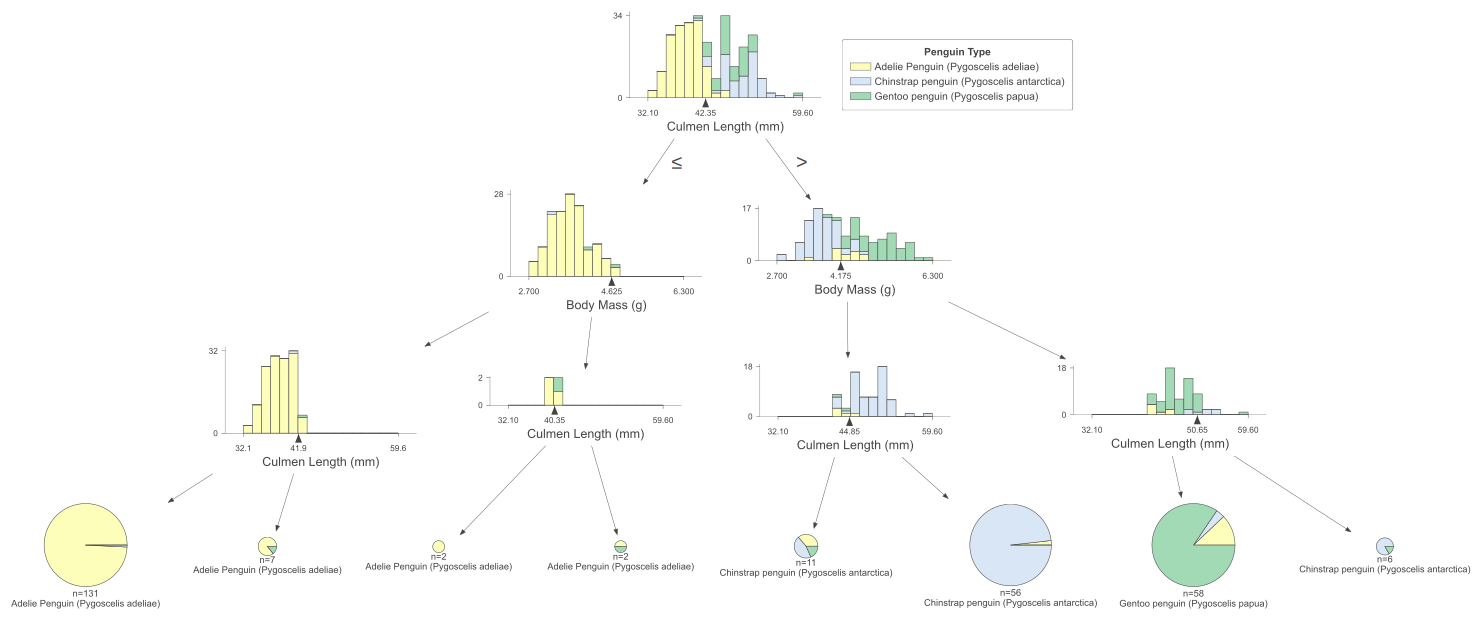

In [8]:
import dtreeviz         # install me with pip install dtreeviz

# To simulate an arbitrary fold
m = x_data.shape[0]
x_train, y_train = x_data[:int(0.8*m),:], y_data[:int(0.8*m),]
clf.fit(x_train, y_train)


plt.style.use("default")
viz = dtreeviz.model(clf, x_train, y_train, target_name='Penguin Type', feature_names=x_data_pd.columns, class_names=np.unique(y_data_pd))
viz.view(scale=1.4) 

```python
TODO 4: What do you think makes splitting at 4175 for the second node in the second level better than any other value? 
```

In [9]:
"""
Observation:    This value is the best at separating the "Blue" and "Green" penguins which are the majority of penguins in this node.
                The "Yellow" ones are very few causing minimal possible impurity in the resulting two nodes.
"""

'\nObservation:    This value is the best at separating the "Blue" and "Green" penguins which are the majority of penguins in this node.\n                The "Yellow" ones are very few causing minimal possible impurity in the resulting two nodes.\n'

```python
TODO 5: How many decision rules where found by this decision tree? Which three rules are the strongest and why?
```

In [10]:
"""
8 Leaf Nodes corresponding to 8 decision rules.
One, three, and six as they result in the purest leaf nodes.
"""

'\n8 Leaf Nodes corresponding to 8 decision rules.\nOne, three, and six as they result in the purest leaf nodes.\n'

Now as we have seen, the 90% accuracy is not so satisfactory. Let's dee if we can do better with hyperparameter search.

#### 🔍 Initialize Random Search

In [11]:
# TODO 6: Define a DecisionTree classifier with random_state=42
clf = DecisionTreeClassifier(random_state=42)

# TODO 7: Define the hyperparameter search distribution
param_dist = {
    'min_samples_split': range(2, 51),                      # 2 to 50
    'min_samples_leaf': range(1, 21),                       # 1 to 20
    'max_depth': range(5, 51, 5),                           # 5 to 50 with step of 5
    'min_impurity_decrease': np.linspace(0.1, 0.3, 20)      # Decide a reasonable range here (with 20 values)
}

# TODO 8: Initialize the Random Search object with 200 iterations, 5-fold cross-validation and random_state=42
clf_searched = RandomizedSearchCV(clf, param_dist, n_iter=200, cv=5, random_state=42)

#### 🔍 Perform the Search

In [12]:
# fit the wrapped model (i.e., search and set the best hyperparameters)
clf_searched.fit(x_data, y_data)

### let's look at the top scores and the used hyperparameters:
relevant_columns = ['param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'param_min_impurity_decrease', 
                    'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = pd.DataFrame(clf_searched.cv_results_)[relevant_columns].round(decimals=3).sort_values(by='rank_test_score')
# above we filtered the clf_searched.cv_results_ as it has other irrelevant columns then rounded all values in it and sorted by score

cv_results_df.head(10)

,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
0,48,9,35,0.142105,0.915,0.03,1
126,40,1,10,0.152632,0.915,0.03,1
123,10,5,35,0.163158,0.915,0.03,1
114,26,3,10,0.131579,0.915,0.03,1
113,16,2,50,0.173684,0.915,0.03,1
112,22,13,30,0.163158,0.915,0.03,1
111,23,17,20,0.152632,0.915,0.03,1
110,4,9,10,0.173684,0.915,0.03,1
105,22,3,20,0.131579,0.915,0.03,1
103,34,12,45,0.173684,0.915,0.03,1


As we can see, the best score is not that good. Let's plot to understand more:

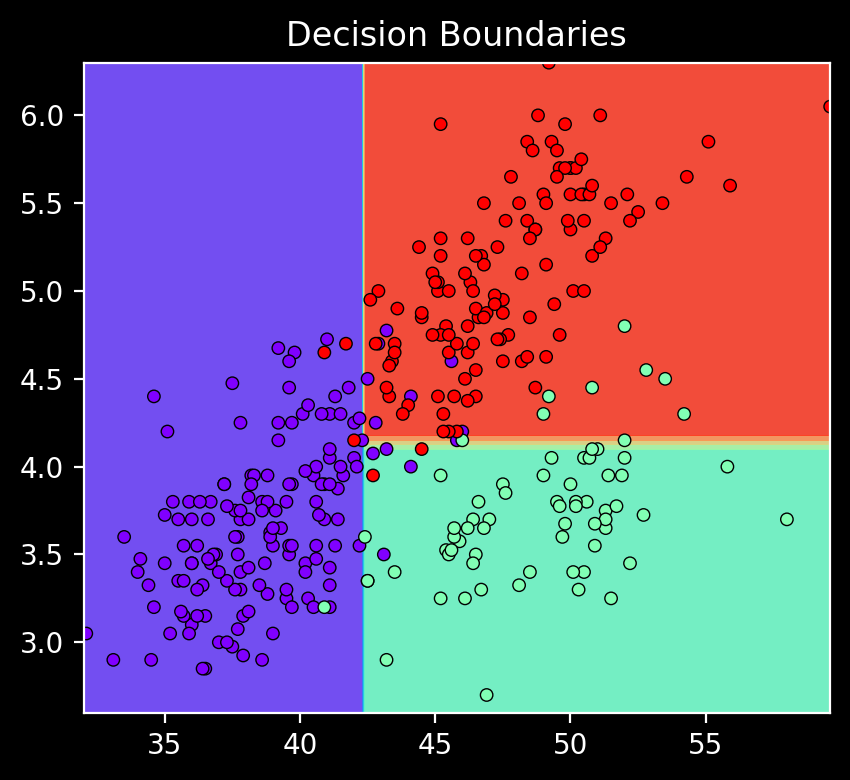

In [13]:
plot_model_contours(clf_searched,  x_data, y_data, trained=True)

```python
TODO 9: Given the plot, comment on what disadvantage of decision trees, as covered in the lecture, is most likely the reason for the mediocre performance. Comparing the boundary to the ideal decision boundary shall be helpful in this.
```

In [14]:
'''
Lecture Slides: Only axis-aligned splits of data (continuous data).
Explanation:    Decision trees split the data along the axes of the feature space. 
                This means that at each node, the tree chooses one feature and makes a binary split along a value of that feature. 
                This is what is meant by "axis-aligned splits".
                
                The disadvantage of this approach is that it may not capture relationships in the data that are not aligned with the axes. 
                For example, if there is a diagonal trend in the data, a decision tree would need to make a series of orthogonal splits to approximate that trend, 
                which could result in a more complex and less interpretable tree.

I did not understand this point from the lecture, so I asked copilot, and I am not sure that I understand his response fully.
'''

'\nLecture Slides: Only axis-aligned splits of data (continuous data).\nExplanation:    Decision trees split the data along the axes of the feature space. \n                This means that at each node, the tree chooses one feature and makes a binary split along a value of that feature. \n                This is what is meant by "axis-aligned splits".\n                \n                The disadvantage of this approach is that it may not capture relationships in the data that are not aligned with the axes. \n                For example, if there is a diagonal trend in the data, a decision tree would need to make a series of orthogonal splits to approximate that trend, \n                which could result in a more complex and less interpretable tree.\n\nI did not understand this point from the lecture, so I asked copilot, and I am not sure that I understand his response fully.\n'

### 🌀 Decision Trees and Overfitting:

Hyperparameters: 100%|██████████| 8/8 [00:00<00:00, 58.58it/s]


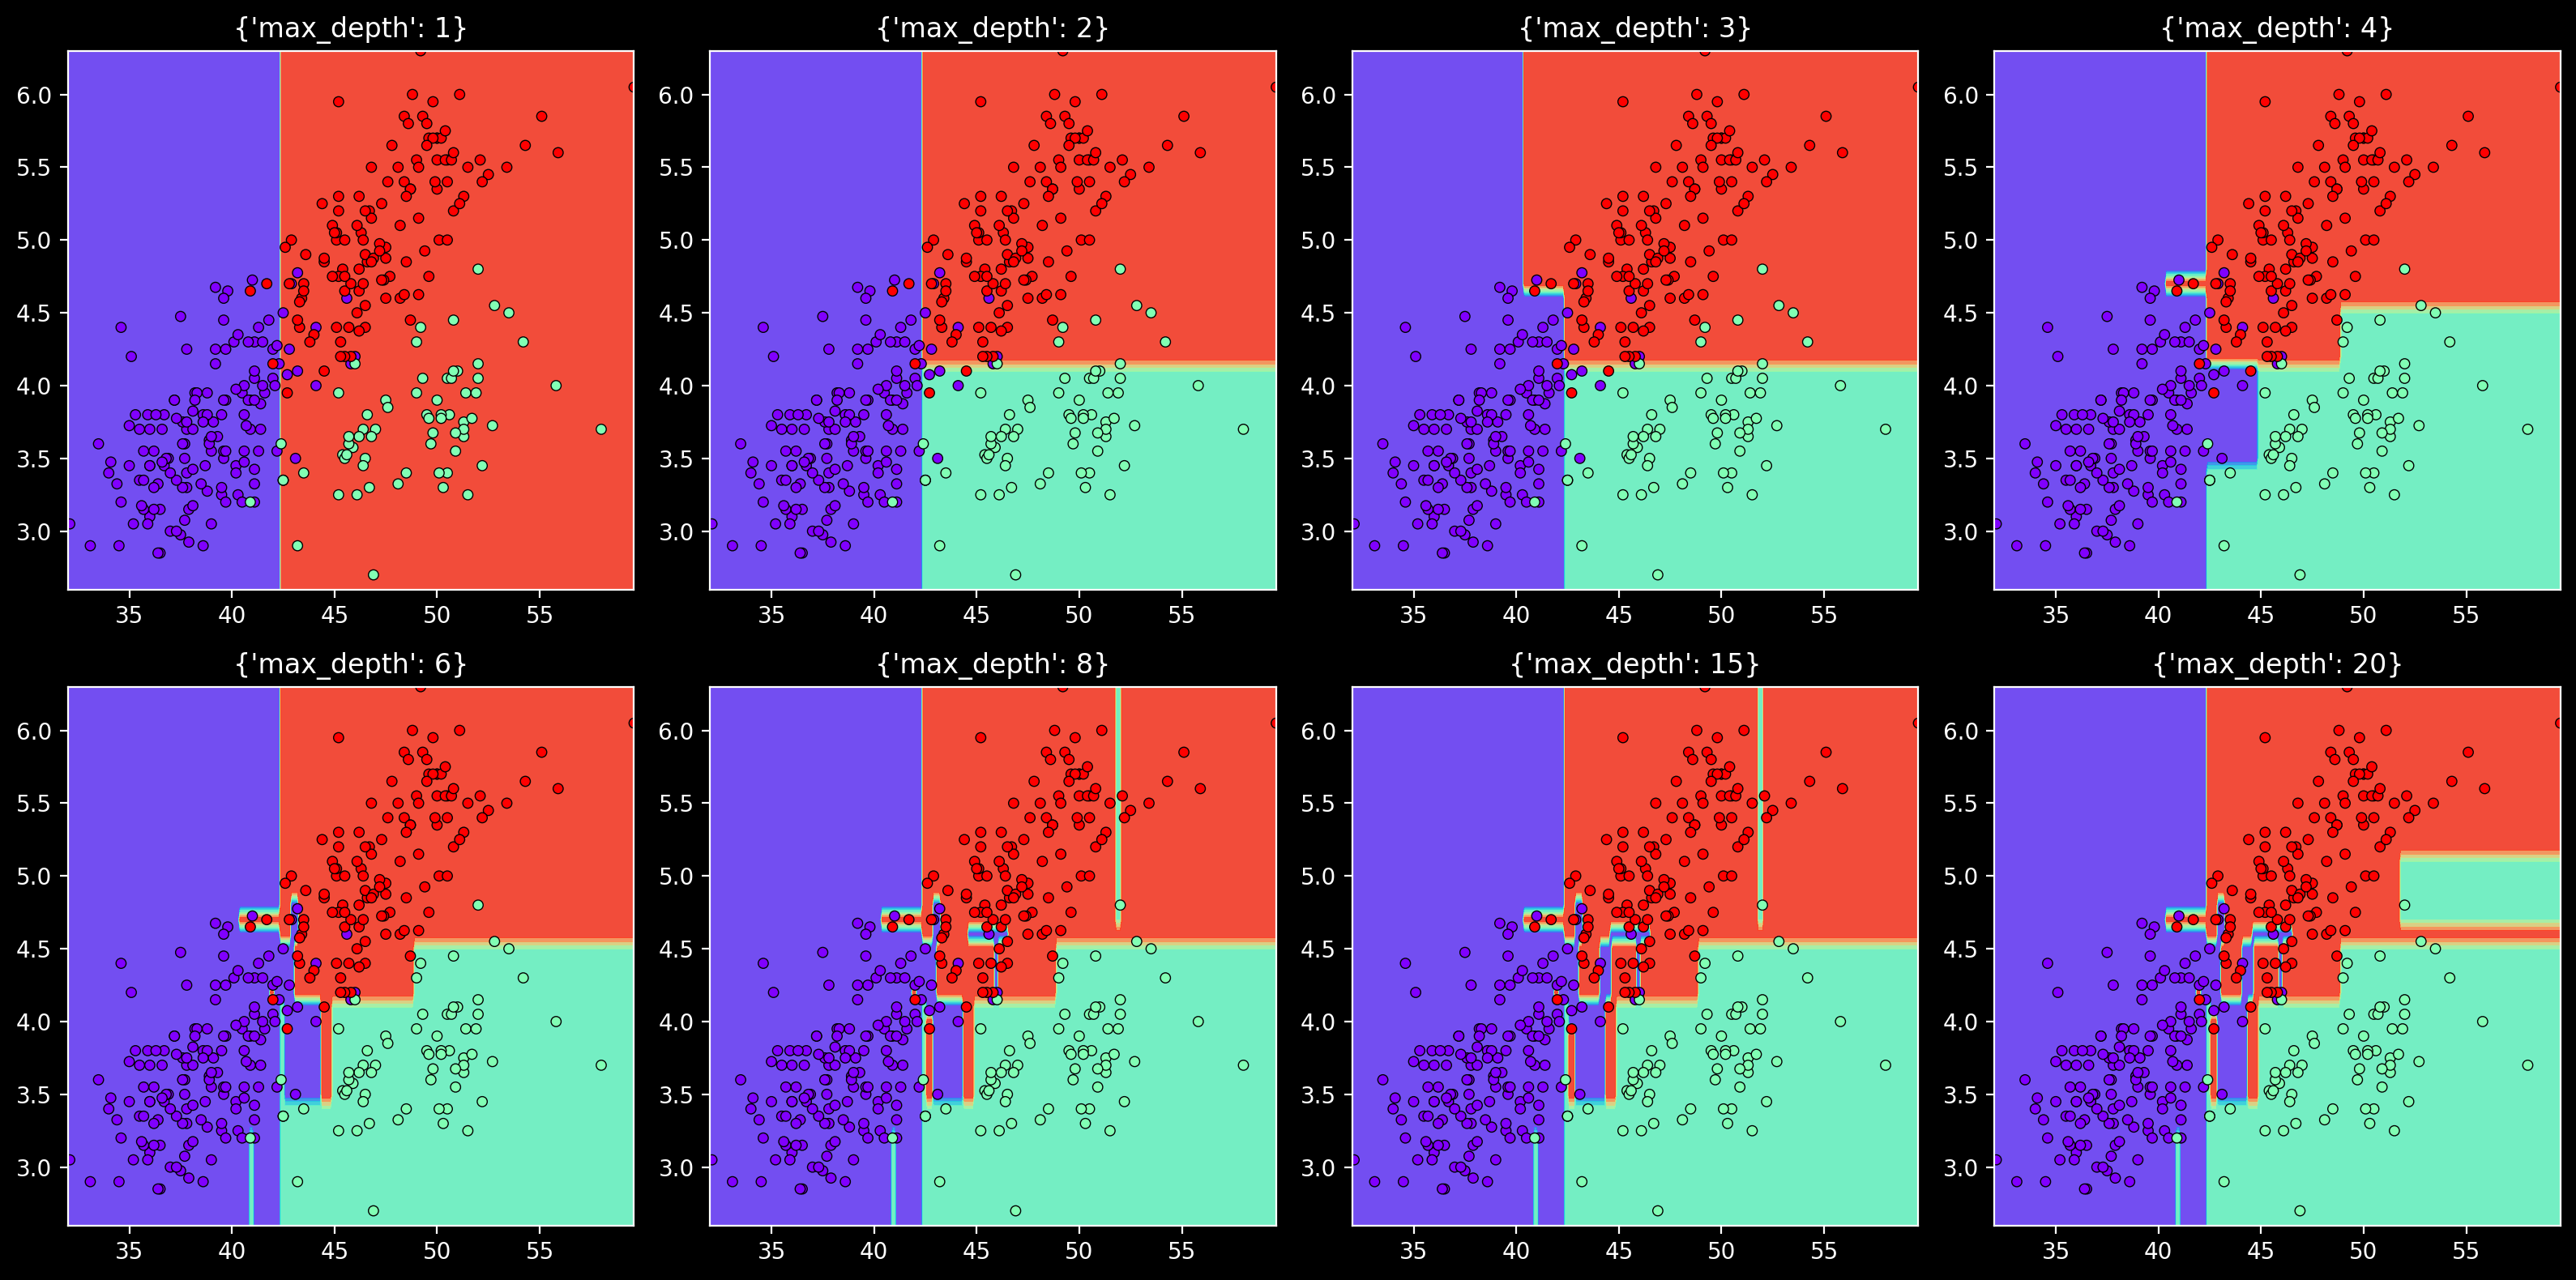

In [15]:
# Define the DecisionTreeClassifier model
dt_model = DecisionTreeClassifier()

# TODO 10: Use depth [1, 2, 3, 4, 6, 8, 15, 50]
hyperparams_list = [
    {'max_depth': 1},
    {'max_depth': 2},
    {'max_depth': 3},
    {'max_depth': 4},
    {'max_depth': 6},
    {'max_depth': 8},
    {'max_depth': 15},
    {'max_depth': 20}
]

# Plot decision boundaries. 
plot_model_contours(dt_model, x_data, y_data, hyperparams_list=hyperparams_list)

```python
TODO 11: Given this, how does depth affect overfitting? Which depth seems the most optimal from the selection above?
```

In [16]:
'''
Increasing the max_depth increases the overfitting of the model.
The output the model with max_depth = 4 seems resonable.
'''

'\nIncreasing the max_depth increases the overfitting of the model.\nThe output the model with max_depth = 4 seems resonable.\n'

####  🌀 Confirmatory Analysis for Overfitting

Hyperparameters: 100%|██████████| 8/8 [00:00<00:00, 50.50it/s]


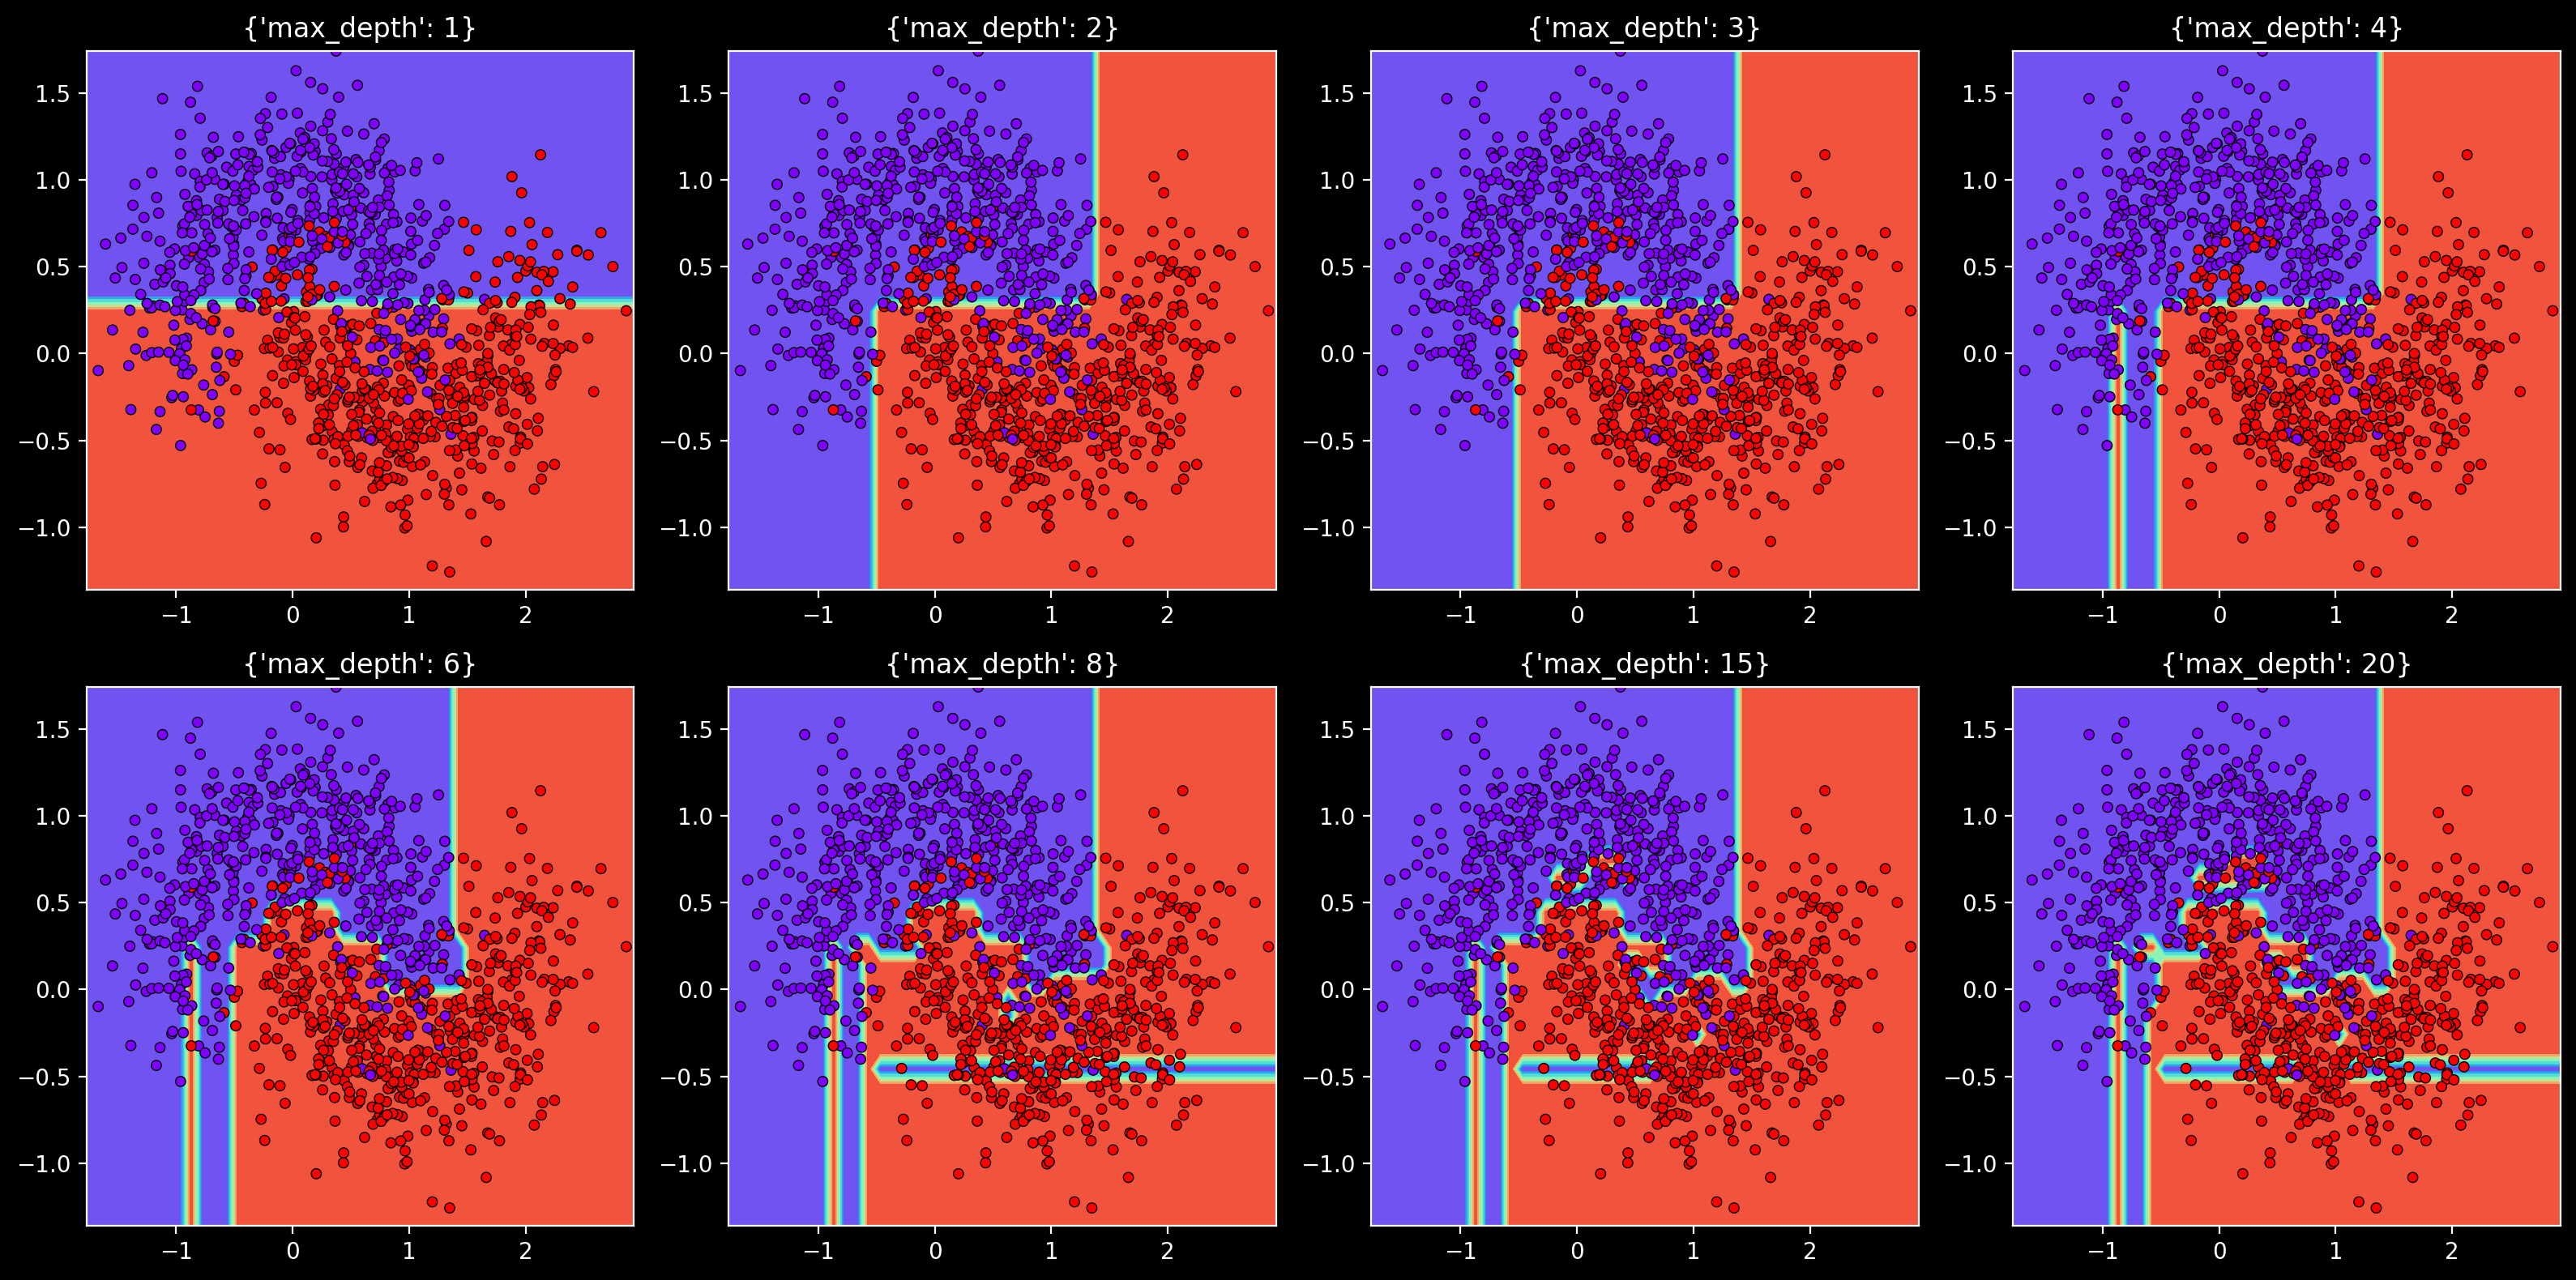

In [17]:
from sklearn.datasets import make_moons

# TODO 12: Call make_moons with n_samples=1000, noise=0.3 and random_state=42
x_data_m, y_data_m = make_moons(n_samples=1000, noise=0.3, random_state=42)
plot_model_contours(DecisionTreeClassifier(), x_data_m, y_data_m, hyperparams_list=hyperparams_list)

<div align="center">
    <img src="https://i.imgur.com/LMiA2O5.gif" width=800/>
</div>